# Real Data

In this notebook I learnt how to download and read Real GW Data and try to apply the optimization to an event to see how much does my result differ from the data of the web. I'm obtaining the Data from gwosc.org.

In [4]:
from gwpy.timeseries import TimeSeries as gwpy_TimeSeries

filename = 'H-H1_GWOSC_4KHZ_R1-1267963136-32.hdf5'
# filename = 'H-H1_GWOSC_4KHZ_R1-1267149494-32.hdf5'


# Note the format argument (see doc)
data = gwpy_TimeSeries.read("./GW_Events/" + filename, format="hdf5.gwosc")
print(data)



TimeSeries([-1.08115107e-19, -8.58975597e-20, -8.82585600e-20,
            ..., -1.24576717e-21,  2.05513654e-20,
             1.16149282e-20]
           unit: dimensionless,
           t0: 1267963136.0 s,
           dt: 0.000244140625 s,
           name: Strain,
           channel: None)


ts = 0.000244140625s, sample rate = 4096.0Hz
[-1.08115107e-19 -8.58975597e-20 -8.82585600e-20 ...
 -1.24576717e-21  2.05513654e-20  1.16149282e-20]
Duration 32
GPSstart 1267963136


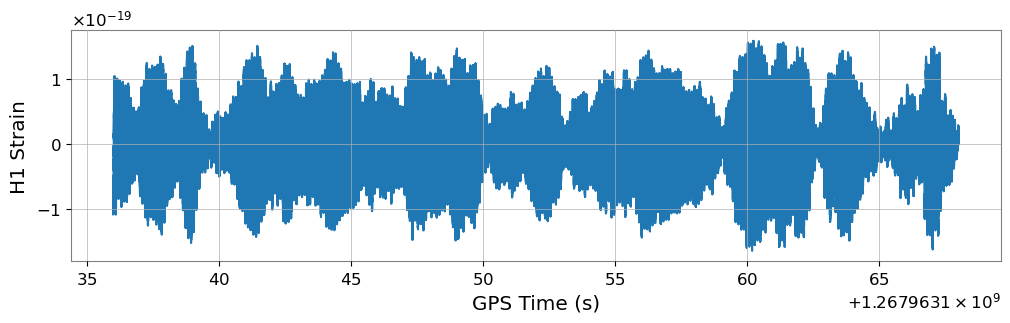

In [5]:
import h5py
import matplotlib.pyplot as plt 
import numpy as np

dataFile = h5py.File("./GW_Events/" + filename, 'r')

#--------------------
# Read in strain data
#--------------------
strain = dataFile['strain']['Strain']
ts = dataFile['strain']['Strain'].attrs['Xspacing']
print(f"ts = {ts}s, sample rate = {1/ts}Hz")
print(strain[()])

#-------------------------
# Print out some meta data
#-------------------------
metaKeys = dataFile['meta'].keys()
meta = dataFile['meta']
#for key in metaKeys:
#    print(key, meta[key])
print("Duration", meta["Duration"][()])
print("GPSstart", meta["GPSstart"][()])

#---------------------
# Create a time vector
#---------------------
gpsStart = meta['GPSstart'][()]
duration = meta['Duration'][()]
gpsEnd   = gpsStart + duration

time = np.arange(gpsStart, gpsEnd, ts)

#---------------------
# Plot the time series
#---------------------
plt.figure(figsize=(12, 3))
plt.plot(time, strain[()])
plt.xlabel('GPS Time (s)')
plt.ylabel('H1 Strain')
plt.show()

In [6]:
from pycbc.types import TimeSeries, FrequencySeries

# Note the format argument (see doc)
data = gwpy_TimeSeries.read("./GW_Events/" + filename, format="hdf5.gwosc")

strain = data.value
delta_t = data.dt.value
epoch = data.t0.value

print(strain)

strain_data = TimeSeries(strain, delta_t = delta_t, epoch = epoch)

print(strain_data)

[-1.08115107e-19 -8.58975597e-20 -8.82585600e-20 ...
 -1.24576717e-21  2.05513654e-20  1.16149282e-20]
[-1.08115107e-19 -8.58975597e-20 -8.82585600e-20 ...
 -1.24576717e-21  2.05513654e-20  1.16149282e-20]


# Let's Simulate a BH with the same parameters as the one we downloaded. And compare the matches.

In [7]:
import math
import lal
import lalsimulation as lalsim
import random as rnd
import copy
import time 

from pycbc.filter import match as simple_match, optimized_match
from pycbc.psd import aLIGOZeroDetHighPower
from pycbc.waveform.utils import coalign_waveforms



In [8]:
def chirp_mass_function(masses:list)->float:

    return ((masses[0]*masses[1])**(3/5))/((masses[0]+masses[1])**(1/5))


def eff_spin_function(masses:list, spins:list)->float:

    return (spins[0]*masses[0]+spins[1]*masses[1])/(masses[0]+masses[1])


class params: # Class with all the basic information mandatory to simulate a GW
    def __init__(self, masses:tuple, spin1:tuple = (0,0,0) ,spin2:tuple= (0,0,0), r: float = 1e6 * lal.PC_SI,
                  incl:float = 0, phiRef:float = 0, longAscNodes:float=0, ecc:float = 0, meanPerAno:float = 0):
        # Atributo de instancia (Se vincula a la instancia)
        self.m1: float = masses[0] # Mass of the first Black Hole
        self.m2: float = masses[1] # Mass of the second Black Hole
        self.s1x:float = spin1[0] # First Component of the dimensionless spin parameter of the first Black Hole
        self.s1y:float = spin1[1] # Second Component of the dimensionless spin parameter of the first Black Hole
        self.s1z:float = spin1[2] # Third Component of the dimensionless spin parameter of the first Black Hole
        self.s2x:float = spin2[0] # First Component of the dimensionless spin parameter of the second Black Hole
        self.s2y:float = spin2[1] # Second Component of the dimensionless spin parameter of the second Black Hole
        self.s2z:float = spin2[2] # Third Component of the dimensionless spin parameter of the second Black Hole
        self.distance:float = r # Distance to the binary system
        self.inclination:float = incl # Angle of inclination of the system with respect to the earth
        self.phiRef:float = phiRef
        self.longAscNodes:float = longAscNodes
        self.eccentricity:float = ecc # Eccentricity of the binary system
        self.meanPerAno : float = meanPerAno # Parameter for the simulation of a system with eccentricity


    def Q(self) -> float: # Chirp Mass of the binary system
        return self.m1/self.m2


    def chirp_mass(self) -> float: # Chirp Mass of the binary system
        return chirp_mass_function([self.m1, self.m2])
    

    def eff_spin(self) -> float: # Effective Spin Parameter of the binary system
        return eff_spin_function([self.m1, self.m2], [self.s1z, self.s2z])
    
    
    def cambiar_valor_paso(self, n_param: int, h:float, a:float) -> None: # Function to sum a step to some parameter, useful to obtain the derivative
        param_keys = list(self.__dict__.keys())
        param_values = list(self.__dict__.values())
        atributo = param_keys[n_param]
        
        setattr(self, atributo, param_values[n_param]+a*h)

    def __str__(self) -> str: # String to format how does print(params) work
        return f"mass1: {self.m1} | mass2: {self.m2} | spin1: {self.s1x, self.s1y, self.s1z}| spin2: {self.s2x, self.s2y, self.s2z}, | distance: {self.distance}, |inclination: {self.inclination}, |phiRef: {self.phiRef}, |longAscNodes: {self.longAscNodes}, |eccentricity: {self.eccentricity}| meanPerAno: {self.meanPerAno}"
    

In [9]:
def simulationTD_IMRPhenomTPHM(parameters: params, delta_T:float, f_min:float, f_ref:float)->tuple:

    Approximant = "IMRPhenomTPHM"

    # Modes
    mode_list = [[2, 2], [2, -2]]

    # Create the waveform parameters structure
    waveform_params = lal.CreateDict()

    mode_array = lalsim.SimInspiralCreateModeArray()
    for l, m in mode_list:
        lalsim.SimInspiralModeArrayActivateMode(mode_array, l, m)
    lalsim.SimInspiralWaveformParamsInsertModeArray(waveform_params, mode_array)


    with lal.no_swig_redirect_standard_output_error():
    # Generate the waveform
        hplus, hcross = lalsim.SimInspiralChooseTDWaveform(**parameters.__dict__,
        deltaT=delta_T, f_min=f_min, f_ref=f_ref, params=waveform_params, approximant=lalsim.GetApproximantFromString(Approximant)
        )

    # Extract time series for both plus (h_plus) and cross (h_cross) polarizations
    h_plus = hplus.data.data
    h_cross = hcross.data.data 
    time = np.arange(len(h_plus)) * delta_T

    return h_plus, h_cross, time # The data is returned as Numpy arrays, we lost information of the epoch, etc which we won't use in this example

In [10]:
from pycbc.psd import welch



def perform_match(hnr, hap, f_lower, f_high, optimized = False, return_phase = False)->tuple:
    FD = isinstance(hnr, FrequencySeries)
    if not FD: 
        hnr, hap = hnr.real(), hap.real()
    
    # Match signal sizes
    length = max(len(hnr), len(hap))
    hnr.resize(length); hap.resize(length)

    # Compute PSD
    if FD: 
        delta_f = hnr.delta_f
    else:
        delta_f = 1/hnr.duration
        length = length//2 + 1
    
    psd = aLIGOZeroDetHighPower(length, delta_f, f_lower)

    """ seg_len=int(4*hnr.sample_rate)
    seg_stride=int(seg_len/2)
    num_segments = (len(hnr) - seg_len) // seg_stride + 1
    total_samples_used = (num_segments - 1) * seg_stride + seg_len

    print(seg_len)
    print(seg_stride)
    print(num_segments)
    print(total_samples_used)
    print(len(hnr)) 

    # Estimate the PSD using Welch's method
    psd = welch(hnr, seg_len=seg_len, seg_stride=seg_stride, avg_method='median')"""

    
    # Compute Match
    match_kwargs = dict(vec1 = hnr, vec2 = hap, psd = psd, low_frequency_cutoff = f_lower, high_frequency_cutoff = f_high, return_phase = return_phase)
    return optimized_match(**match_kwargs) if optimized else simple_match(**match_kwargs, subsample_interpolation = True)

In [11]:
mass1_target = 34.2 * lal.MSUN_SI
mass2_target = 27.7 * lal.MSUN_SI

masses_target = (mass1_target, mass2_target)
r_generic = 1e6 * lal.PC_SI

spin1_target = (0,0.0,0.0)
spin2_target = (0,0,0.0)

parameters_target:params = params(masses_target, spin1_target, spin2_target, r = r_generic)
delta_T = 1.0/4096.0 
f_min = 10
f_max = 250
f_ref = f_min

hp_target, hc_target, time_target = simulationTD_IMRPhenomTPHM(parameters_target, delta_T, f_min, f_ref)

# Convert the data obtained from a numpy array to a PyCBC TimeSeries
hp_target = TimeSeries(hp_target, delta_t=delta_T)

0.8552075767502162


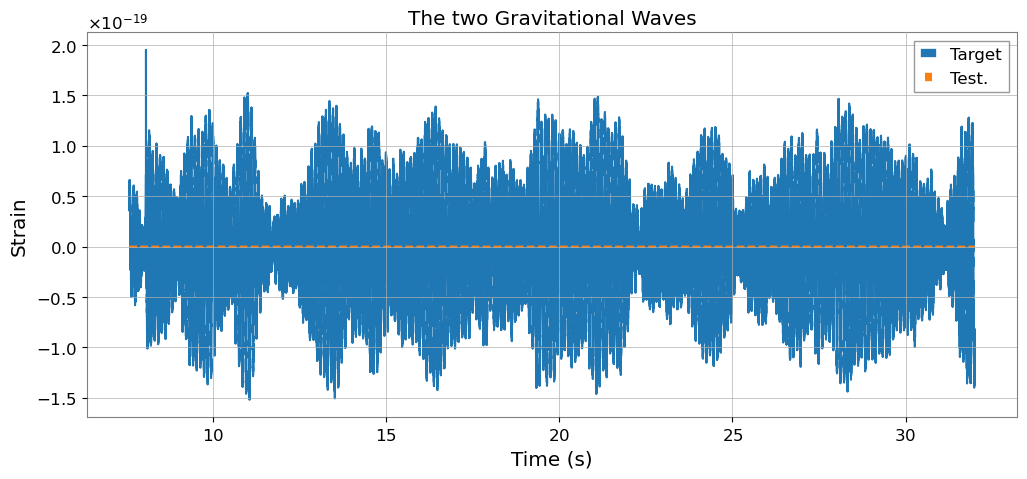

In [12]:
match,_ = perform_match (strain_data, hp_target, f_lower=f_min, f_high=f_max, optimized = True, return_phase = False)
print(1-match)

# Waveforms Coaligned 
h1_aligned, h2_aligned = coalign_waveforms(strain_data, hp_target)

# Plot of the coaligned waveforms
plt.figure(figsize=(12, 5))

N=-100000

plt.plot(h1_aligned.sample_times.data[N:], h1_aligned.data[N:], label = f'Target')
plt.plot(h2_aligned.sample_times.data[N:], h2_aligned.data[N:], label = f'Test.', linestyle='dashed')
plt.title(f'The two Gravitational Waves')
plt.xlabel('Time (s)')
plt.ylabel('Strain')

plt.legend()
plt.show()

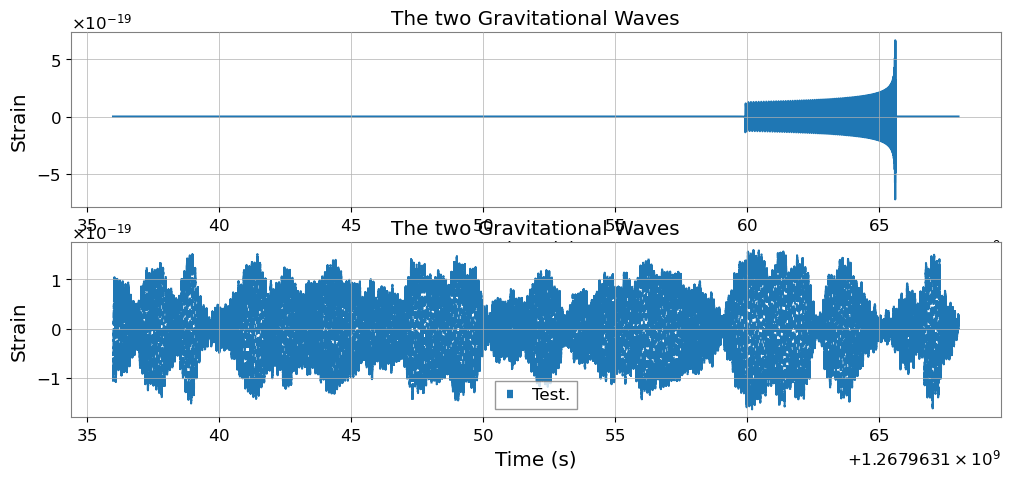

In [13]:
# Waveforms Coaligned 
h1_aligned, h2_aligned = coalign_waveforms(hp_target, strain_data)

# Plot of the coaligned waveforms
plt.figure(figsize=(12, 5))

plt.subplot(2,1,1)
plt.plot(h1_aligned.sample_times, h1_aligned, label = f'Target')
plt.title(f'The two Gravitational Waves')
plt.xlabel('Time (s)')
plt.ylabel('Strain')

plt.subplot(2,1,2)
plt.plot(h2_aligned.sample_times, h2_aligned, label = f'Test.', linestyle='dashed')
plt.title(f'The two Gravitational Waves')
plt.xlabel('Time (s)')
plt.ylabel('Strain')

plt.legend()
plt.show()

# Probamos a hacer una optimizacion simple. Unicamente masas y tercera componente de spins

In [14]:
def M_c_and_q_m(mass_ratio, chirp_mass)->tuple:
    # Function to Calculate the original masses of the black holes given the mass ratio q_m=m1/m2 and the chirp mass

    mass2 = chirp_mass*((1+mass_ratio)/mass_ratio**3)**(1/5)
    mass1 = mass_ratio*mass2
    
    return (mass1, mass2)


def Eff_spin_and_spin1(mass1, mass2, eff_spin, spin2):
    """ Function to Calculate the third component of the spins of the second black holes 
    given the spin of the first one and the effective spin parameter """

    spin1 = (eff_spin*(mass1+mass2)-spin2*mass2)/mass1

    return spin1, spin2


def opt_match_precession(prms:list, grad)->float: # TOTAL OPTIMIZATION IN THE CASE OF BIG MASS RATIO. 
    """ Function that we want to maximize. As nlopt minimizes the functions we instert a minus sign at the end of the computation
    Args:
        prms (list): List of parameters to optimize in this order: [Q_m=m1/m2, M_chirp, eff_spin_parameter, chi_2 (z component), 
                                                                    chi_1(x component), chi_1(y component), incl]
        grad (_type_): We use a derivative-free method but this has to be written because of the systaxis of nlopt
    Returns:
        float: The match of the given parameters multiplied by -1 """

    if prms[0]>20 or prms[0]<1:#or (1/prms[0])>20:
        """ If the ratio of the masses is more than 20 the simulation breaks so we give this case a value of zero (worst possible value).
        The first condition really should not be needed because it is save because of the constraint bounds."""
        return 0

    masses = M_c_and_q_m(prms[0], prms[1]) # Obtain the masses for the given parameters
    spin1z, spin2z = Eff_spin_and_spin1(masses[0], masses[1], prms[2], prms[3]) # Obtain the spins for the given parameters

    spin1 = (prms[4], prms[5], spin1z)

    if (spin1[0]**2+spin1[1]**2+spin1[2]**2>1) or abs(spin2z)>1:
        return 0 # Penalization if the dimensionless spin parameters are more than one
    
    parameters = params(masses, spin1, (0, 0, spin2z), incl= prms[6]) # We write the parameters using the params class

    hp, hc, time = simulationTD_IMRPhenomTPHM(parameters, delta_T, f_min, f_ref) # Simulation of the GW
    hp = TimeSeries(hp, delta_t = delta_T) # Writing the GW as a pycbc TimeSeries Class
    match, _ = perform_match(strain_data, hp, f_lower = f_min, f_high = f_max, optimized = True, return_phase = False)

    return -match # The minus sign is because nlopt minimizes the functions



def opt_match_non_precession_non_incl(prms:list, grad)->float: # TOTAL OPTIMIZATION WITHOUT PRECESSION
    """ Function that we want to maximize. As nlopt minimizes the functions we instert a minus sign at the end of the computation
    Args:
        prms (list): List of parameters to optimize in this order: [Q_m=m1/m2, M_chirp, eff_spin_parameter, chi_2 (third component)]
        grad (_type_): We use a derivative-free method but this has to be written because of the systaxis of nlopt
    Returns:
        float: The match of the given parameters multiplied by -1 """

    match = -opt_match_precession([prms[0], prms[1], prms[2], prms[3], 0, 0, 0], grad)

    return - match # The minus sign is because nlopt minimizes the functions


def opt_match_mass_and_effspin(prms:list, grad)->float: # ONLY OPTIMIZES THE MASSES AND EFFECTIVE SPIN
    """ Function that we want to maximize. As nlopt minimizes the functions we instert a minus sign at the end of the computation
    Args:
        prms (list): List of parameters to optimize in this order: [Q_m=m1/m2, M_chirp, eff_spin]
        grad (_type_): We use a derivative-free method but this has to be written because of the systaxis of nlopt
    Returns:
        float: The match of the given parameters multiplied by -1 """

    match = - opt_match_precession([prms[0], prms[1], prms[2], 0, 0, 0, 0], grad)

    return - match # The minus sign is already in opt_match_non_precession


In [15]:
import nlopt 
from termcolor import colored

def opt_first(prms_initial:list)->tuple:

    opt = nlopt.opt(nlopt.LN_NELDERMEAD, 3) # Define the first global optimization
    opt.set_lower_bounds([1, lal.MSUN_SI, -1]) # Lower constraints
    opt.set_upper_bounds([20, 175*lal.MSUN_SI, 1]) # High contraints (More than 20 may give a problemwith the minimum frequency)
    opt.set_min_objective(opt_match_mass_and_effspin)
    opt.set_xtol_rel(1e-2) # Tolerance used for computations
    #opt.set_ftol_rel(-1+1e-2)

    prms_final = opt.optimize(prms_initial)
    max_match = -opt.last_optimum_value() # Obtain the best value of the optimization

    print(colored(f"Number of Evaluations: {opt.get_numevals()} made by initial conditions: {prms_initial}", "cyan"))

    return max_match, prms_final

def opt_second_not_incl(prms_initial:list)->tuple:

    opt = nlopt.opt(nlopt.LN_NELDERMEAD, 4) # Define the local optimization
    opt.set_lower_bounds([1, lal.MSUN_SI, -1, -1]) # Same boundaries as before
    opt.set_upper_bounds([20, 175*lal.MSUN_SI, 1, 1]) # Same boundaries as before
    opt.set_min_objective(opt_match_non_precession_non_incl)
    #opt.set_ftol_rel(-1+1e-4) # Tolerance used for tests
    opt.set_xtol_rel(1e-3) # Tolerance used for computations

    prms_final = opt.optimize(prms_initial) # We use the parameters obtained by the global optimization as the starting point
    max_match = -opt.last_optimum_value()

    print(colored(f"Number of Evaluations: {opt.get_numevals()} made by initial conditions: {prms_initial[3]}", "cyan"))

    return max_match, prms_final

In [16]:
from joblib import Parallel, delayed

def main_not_extrinsic(): 

    # We write the initial values for the optimization (it is not important if the first optimization is global)
    n_workers = 6

    # We write the initial values for the optimization (it is not important if the first optimization is global)
    mass1_template = [8*lal.MSUN_SI, 8*lal.MSUN_SI, 100*lal.MSUN_SI, 100*lal.MSUN_SI, 40*lal.MSUN_SI, 40*lal.MSUN_SI]
    mass2_template = [4*lal.MSUN_SI, 4*lal.MSUN_SI, 10*lal.MSUN_SI, 10*lal.MSUN_SI, 10*lal.MSUN_SI, 10*lal.MSUN_SI]
    eff_spin_template = [-0.5, 0.5, 0.7, -0.7, 0.7, -0,7]

    prms_initial = []
    for i in range(n_workers):
        mass_ratio_template = mass1_template[i]/mass2_template[i]
        chirp_mass_template = chirp_mass_function([mass1_template[i], mass2_template[i]])
        prms_initial.append([mass_ratio_template, chirp_mass_template, eff_spin_template[i]])

    print("Starting Hierarchical Optimization")
    print("First optimization: Masses and Effective Spin")
    time_initial=time.time()

    results_multiprocess = Parallel(n_jobs=n_workers)(delayed(opt_first)(prms) for prms in prms_initial)
    
    max_match=0 
    for i in range(n_workers):
        if (results_multiprocess[i][0])>max_match:
            max_match = results_multiprocess[i][0]
            prms_final = results_multiprocess[i][1]
            best_worker = i 
    print(f"The best initial parameters were {prms_initial[best_worker]}")
    

    masses_final = M_c_and_q_m(prms_final[0], prms_final[1])
    print(f"Masses: {masses_final[0]/lal.MSUN_SI, masses_final[1]/lal.MSUN_SI}")


    # max_match, prms_final = opt_original_first(prms_initial[3])
    
    print(f"The match of the first optimization is: {max_match}. It took {time.time()-time_initial} seconds.")
    print(f"The first optimization has obtain the following parameters: {prms_final[0], prms_final[1]/lal.MSUN_SI, prms_final[2]}.") # Print the parameters calculated by the global optimization

    print(f"Second Optimization: Spin2z and Relevant Precession Parameters")

    n_workers=5
        
    spin2z_template = [0.0, -0.7, 0.7, -0.7, 0.7]
    #spin1x_template = [0.4, 0.0, 0.0, -0.4, -0.4]
    #spin1y_template = [0.4, 0.0, 0.0, 0.4, 0.4]
    prms_initial = []
    for i in range(n_workers):
        prms_initial.append([prms_final[0], prms_final[1], prms_final[2], spin2z_template[i]])#, spin1x_template[i], spin1y_template[i]])

    results_multiprocess = Parallel(n_jobs=n_workers)(delayed(opt_second_not_incl)(prms) for prms in prms_initial)
    
    max_match=0 
    for i in range(n_workers):
        if (results_multiprocess[i][0])>max_match:
            max_match = results_multiprocess[i][0]
            prms_final = results_multiprocess[i][1]
            best_worker = i 
    print(f"The best initial parameters were {prms_initial[best_worker]}")

    # max_match, prms_final = opt_precession_high_Q(prms_initial[2])

    masses_final = M_c_and_q_m(prms_final[0], prms_final[1])
    spin1z_final, spin2z_final = Eff_spin_and_spin1(masses_final[0], masses_final[1], prms_final[2], prms_final[3])

    Comp_time = time.time()-time_initial

    print(colored(f"The match of the total optimization is: {max_match}. The complete optimization took {Comp_time} seconds.", "magenta"))
    
    print(f"Masses: {masses_final[0]/lal.MSUN_SI, masses_final[1]/lal.MSUN_SI}")
    print(f"Parameters: {prms_final}")
    print(f"chirp mass: {prms_final[1]/lal.MSUN_SI}, chirp mass target: {parameters_target.chirp_mass()/lal.MSUN_SI}")
    print(f"effective spin parameter: {prms_final[2]}, eff_spin_target: {parameters_target.eff_spin()}")
    
    # Waveforms Coaligned 
    hp_test, hc_test, time_test = simulationTD_IMRPhenomTPHM(params(masses_final, (0,0,spin1z_final), (0,0,spin2z_final)), 
                                                             delta_T, f_min, f_ref)
    h1_aligned, h2_aligned = coalign_waveforms(strain_data, TimeSeries(hp_test, delta_t=delta_T))

    # Plot of the coaligned waveforms
    plt.figure(figsize=(12, 5))

    plt.subplot(2,1,1)
    plt.plot(h1_aligned.sample_times, h1_aligned, label = f'Target')
    plt.plot(h2_aligned.sample_times, h2_aligned, label = f'Template.', linestyle='dashed')
    plt.title(f'The mismatch between the gravitational waves is {1-max_match}')
    plt.xlabel('Time (s)')
    plt.ylabel('Strain')

    plt.subplot(2,1,2)

    N_dataPoints=-30000 
    plt.plot(h1_aligned.sample_times.data[N_dataPoints:], h1_aligned.data[N_dataPoints:], label = f'Target')
    plt.plot(h2_aligned.sample_times.data[N_dataPoints:], h2_aligned.data[N_dataPoints:], label = f'Test.', linestyle='dashed')
    plt.title(f'The mismatch between the gravitational waves is {1-max_match}')
    plt.xlabel('Time (s)')
    plt.ylabel('Strain')

    plt.legend()
    plt.show() # Mostrar la imagen


    return max_match, Comp_time, prms_final

Starting Hierarchical Optimization
First optimization: Masses and Effective Spin


Number of Evaluations: 37 made by initial conditions: [10.0, 4.900353084608317e+31, -0.7]
Number of Evaluations: 46 made by initial conditions: [10.0, 4.900353084608317e+31, 0.7]
Number of Evaluations: 54 made by initial conditions: [4.0, 3.3109140309583986e+31, 0]
Number of Evaluations: 66 made by initial conditions: [2.0, 9.677421299209352e+30, -0.5]
Number of Evaluations: 86 made by initial conditions: [4.0, 3.3109140309583986e+31, 0.7]
Number of Evaluations: 65 made by initial conditions: [2.0, 9.677421299209352e+30, 0.5]
The best initial parameters were [10.0, 4.900353084608317e+31, -0.7]
Masses: (np.float64(152.658277848499), np.float64(9.97065064528126))
The match of the first optimization is: 0.34927426709051396. It took 13.77790904045105 seconds.
The first optimization has obtain the following parameters: (np.float64(15.310763888888888), np.float64(29.324239298807978), np.float64(-0.7953124999999999)).
Second Optimization: Spin2z and Relevant Precession Parameters
Number of Ev

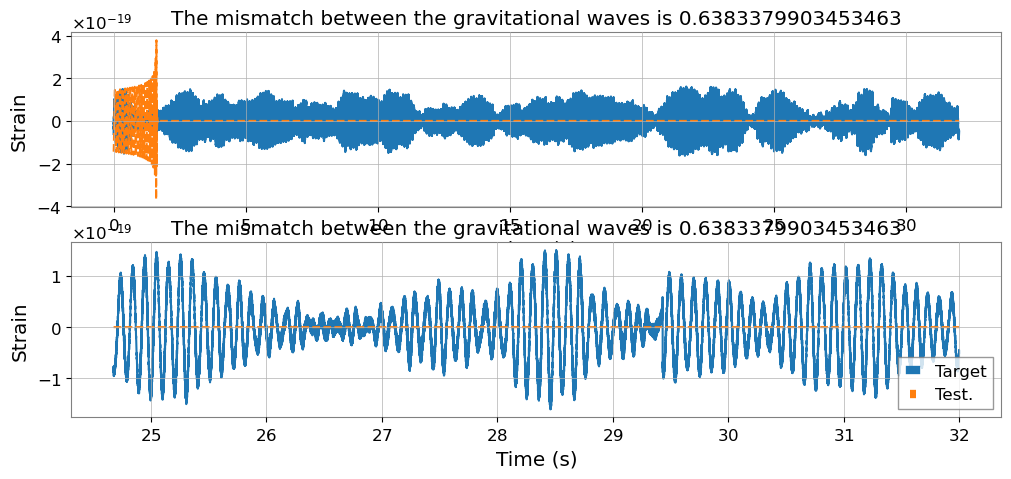

1-match = 0.6383379903453463, Cumputing time = 23.67474937438965 seconds
Final Parameters: [ 1.40582697e+01  5.75299805e+31 -8.66098486e-01  9.98834819e-01]
mass1: 6.800361757787334e+31 | mass2: 5.5078953418336e+31 | spin1: (0, 0.0, 0.0)| spin2: (0, 0, 0.0), | distance: 3.085677581491367e+22, |inclination: 0, |phiRef: 0, |longAscNodes: 0, |eccentricity: 0| meanPerAno: 0
IMRPhenomTPHM, 0.6383379903453463, 23.67474937438965, 14.058269688815113, 5.752998047602498e+31, -0.8660984859573326, 0.998834818683064
39.519727581043995 28.111373914306288


In [17]:
if __name__ == '__main__': #Llamar al main()


    Fitting_Factor, Comp_time, prms = main_not_extrinsic()

    print(colored(f"1-match = {1-Fitting_Factor}, Cumputing time = {Comp_time} seconds", "green"))
    print(colored(f"Final Parameters: {prms}", "green"))

    print(colored(parameters_target, "yellow"))


    print(f"IMRPhenomTPHM, {1-Fitting_Factor}, {Comp_time}, " 
            f"{prms[0]}, "
            f"{prms[1]}, "
            f"{prms[2]}, "
            f"{prms[3]}" )
    
    mass_fin = M_c_and_q_m(prms[0]/10, prms[1])
    print(mass_fin[0]/lal.MSUN_SI, mass_fin[1]/lal.MSUN_SI)